# Train chosen model

libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from os import path, listdir
from cv2 import imread, resize
from keras.callbacks import EarlyStopping
from tensorflow.keras.applications import vgg16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from random import randint
from typing import Iterable
from seaborn import heatmap

load data

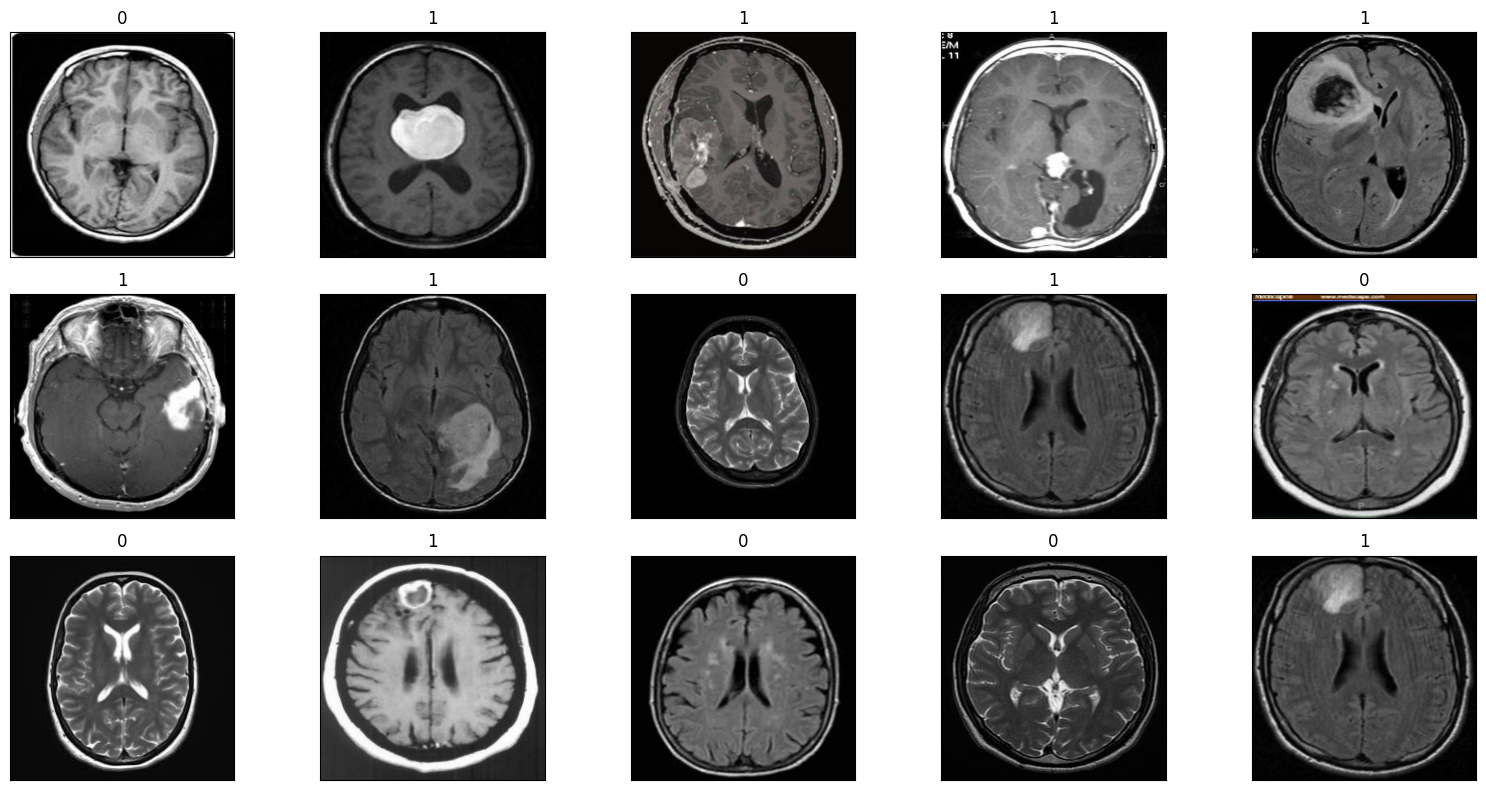

In [ ]:
no_path = '../archive/no'
yes_path = '../archive/yes'
images = []
labels = [] # label 0 is no tumor, label 1 tumor occurs
for path_ in (no_path, yes_path):
    if path_ == no_path:
        default_label = 0
    elif path_ == yes_path:
        default_label = 1
    else:
        raise(Exception("What's going on?? No such file or directory"))
    
    for filename in listdir(path_):
        img_path = path.join(path_, filename)
        
        img = imread(img_path)
        
        # resize to convenient shape for CNN's
        img = resize(img, (224,224))
        
        images.append(img)
        labels.append(default_label)

images = np.array(images)
labels = np.array(labels)

plt.figure(figsize=(16,8))
max_idx = len(labels)-1
for num in range(15):
    i = randint(0,max_idx)
    plt.subplot(3, 5, num + 1)
    plt.imshow(images[i], cmap='gray')
    plt.title(int(labels[i]))
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

split data

In [17]:
random_state = 766
def split_data(*images_list: Iterable, train_size: float=0.8, random_state: int=random_state):
    """Prepare data for CNN's. Split data by sklearn.model_selection.train_test_split, convert to np.array type, and categorize labels.

    Args:
        images_list (Iterable): Allowed inputs are lists, numpy arrays, scipy-sparse matrices or pandas dataframes.
        train_size (float, Optional): Should be between 0.0 and 1.0 and represent the proportion of the dataset to include in the train split. Defaults to 0.8.
        random_state (int, Optional): Controls the shuffling applied to the data before applying the split. Pass an int for reproducible output across multiple function calls. Defaults to 112.
        
    """
    X_train, X_test, y_train, y_test = train_test_split(images, labels, train_size=train_size, random_state=random_state) # images is raw data without being preprocessed, 
    # optionally load here preprocessed data by cnn's own algorithm instead, for example vgg16_images (every cnn has its own prep. algorithm)
    X_train, X_test, y_train, y_test = np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)
    y_train = to_categorical(y_train, num_classes=2)
    y_test = to_categorical(y_test, num_classes=2)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = split_data(images)

# make labels categorical
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

prepare model

In [18]:
# preprocess images to fit for vgg16
vgg16_images = vgg16.preprocess_input(images)
X_train, X_test, y_train, y_test = split_data(vgg16_images)


vgg16_base_model = vgg16.VGG16(
    include_top=False, # set to false to not including classification layers
    # imagenet was trained with range 1000 of classes, we need just 2 - will be added in the next step
    weights='imagenet', # weights to be loaded, pretrained model imagenet, fits to MRI images well
    input_shape=(224, 224, 3),
)

# XXX classification layer + freezing weights from imagenet
for layer in vgg16_base_model.layers: # freeze the layers because models is already pretraind and it isn't neede to train it from scratch
    layer.trainable = False 
### configure output layers :
x = layers.Flatten()(vgg16_base_model.output)
# prevent overfitting by adding drouppout layer
x = layers.Dropout(0.4)(x)
x = layers.Dense(2, activation='softmax')(x)  # 2 klasy
vgg16_model = models.Model(inputs=vgg16_base_model.input, outputs=x)
vgg16_model.summary(show_trainable=True)

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_2 (InputLayer)  │ (None, 224, 224, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block1_conv1 (Conv2D)       │ (None, 224, 224, 64)  │      1,792 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block1_conv2 (Conv2D)       │ (None, 224, 224, 64)  │     36,928 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block1_pool (MaxPooling2D)  │ (None, 112, 112, 64)  │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block2_conv1 (Conv2D)       │ (None, 112, 112, 128) │     73,856 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block2_conv2 (Conv2D)       │ (None, 112, 112, 128) │    147,584 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block2_pool (MaxPooling2D)  │ (None, 56, 56, 128)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_conv1 (Conv2D)       │ (None, 56, 56, 256)   │    295,168 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_conv2 (Conv2D)       │ (None, 56, 56, 256)   │    590,080 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_conv3 (Conv2D)       │ (None, 56, 56, 256)   │    590,080 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_pool (MaxPooling2D)  │ (None, 28, 28, 256)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_conv1 (Conv2D)       │ (None, 28, 28, 512)   │  1,180,160 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_conv2 (Conv2D)       │ (None, 28, 28, 512)   │  2,359,808 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_conv3 (Conv2D)       │ (None, 28, 28, 512)   │  2,359,808 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_pool (MaxPooling2D)  │ (None, 14, 14, 512)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_conv1 (Conv2D)       │ (None, 14, 14, 512)   │  2,359,808 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_conv2 (Conv2D)       │ (None, 14, 14, 512)   │  2,359,808 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_conv3 (Conv2D)       │ (None, 14, 14, 512)   │  2,359,808 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_pool (MaxPooling2D)  │ (None, 7, 7, 512)     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ flatten_2 (Flatten)         │ (None, 25088)         │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_2 (Dropout)         │ (None, 25088)         │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_2 (Dense)             │ (None, 2)             │     50,178 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 14,764,866 (56.32 MB)

 Trainable params: 50,178 (196.01 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

train model

In [19]:
# compile with categorical crossentropy, using adam optimizer, where metric to be valued is recall, accuracy
vgg16_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['recall', 'accuracy'])

# callback to stop epochs when satisfying outcome
early_stopping = EarlyStopping(
    monitor='val_loss',  # metric to be monitored to end alg
    patience=3,    # how much epochs without change to end algorithm
    min_delta=0.02, #if los changes slightly, patience won't take it into account           
    restore_best_weights=True # hold best epoch weights
)

# fit data with validation
vgg16_history = vgg16_model.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)
vgg16_predictions = vgg16_model.predict(X_test)

Epoch 1/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 30s 4s/step - accuracy: 0.6590 - loss: 7.8819 - recall: 0.6590 - val_accuracy: 0.8824 - val_loss: 2.3142 - val_recall: 0.8824
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 29s 4s/step - accuracy: 0.8512 - loss: 3.3495 - recall: 0.8512 - val_accuracy: 0.9020 - val_loss: 2.7818 - val_recall: 0.9020
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 28s 4s/step - accuracy: 0.9172 - loss: 1.4206 - recall: 0.9172 - val_accuracy: 0.9020 - val_loss: 3.9357 - val_recall: 0.9020
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 29s 4s/step - accuracy: 0.9320 - loss: 1.2409 - recall: 0.9320 - val_accuracy: 0.9020 - val_loss: 2.1163 - val_recall: 0.9020
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 28s 4s/step - accuracy: 0.9762 - loss: 0.3636 - recall: 0.9762 - val_accuracy: 0.9216 - val_loss: 2.1883 - val_recall: 0.9216
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 27s 4s/step - accuracy: 0.9988 - loss: 0.0127 - recall: 0.9988 - val_accuracy: 0.9020 - val_loss: 2.4057 - val_recall: 0.9020
Epoch 7/30
7/7 ━━━━━━━━━━━━━

report

In [20]:
best_epoch = min(range(len(vgg16_history.history['val_loss'])), key=lambda i: vgg16_history.history['val_loss'][i])
print(f'Best epoch is: {best_epoch + 1}')

y_test_labels = np.argmax(y_test, axis=1)
vgg16_predictions_classes = np.argmax(vgg16_predictions, axis=1)
print("\nClassification report:")
print(classification_report(y_test_labels, vgg16_predictions_classes))

Best epoch is: 4

Classification report:
              precision    recall  f1-score   support

           0       0.89      0.84      0.86        19
           1       0.91      0.94      0.92        32

    accuracy                           0.90        51
   macro avg       0.90      0.89      0.89        51
weighted avg       0.90      0.90      0.90        51



show output

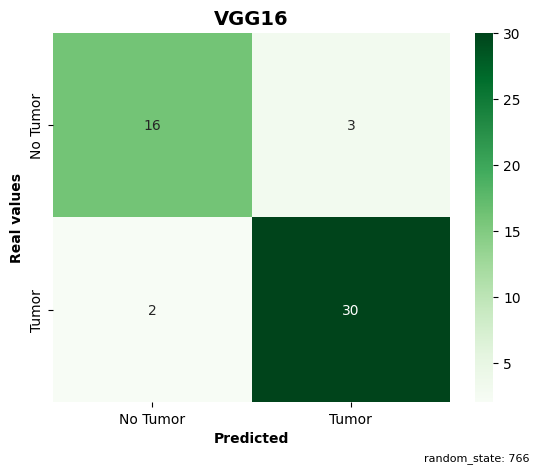

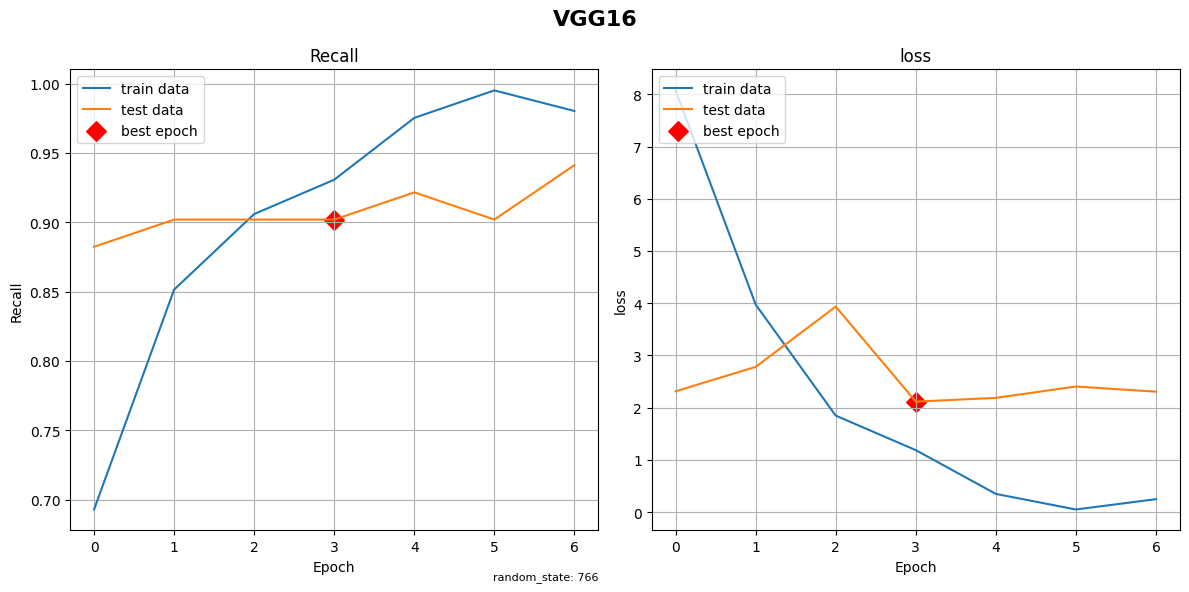

In [ ]:
cf_matrix = confusion_matrix(y_test_labels, vgg16_predictions_classes)
labels_heatmap = ['No Tumor', 'Tumor']
heatmap(cf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=labels_heatmap, yticklabels=labels_heatmap)
plt.title('VGG16', fontweight='bold', fontsize=14)
plt.xlabel("Predicted", fontweight='bold')
plt.ylabel('Real values', fontweight='bold')

plt.text(1.2, -0.15, f"random_state: {random_state}", fontsize=8, color='black', ha='right', va='center', transform=plt.gca().transAxes)
plt.show()


plt.figure(figsize=(12, 6))

# Name
plt.suptitle('VGG16', fontweight='bold', fontsize='16')
# Recall
plt.subplot(1, 2, 1)
plt.plot(vgg16_history.history['recall'], label='train data')
plt.plot(vgg16_history.history['val_recall'], label='test data')
plt.scatter(best_epoch, vgg16_history.history['val_recall'][best_epoch], color='red', marker='D', s=100, label='best epoch')
plt.title('Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.grid()
plt.text(1, -0.1, f"random_state: {random_state}", fontsize=8, color='black', ha='right', va='center', transform=plt.gca().transAxes)

# loss
plt.subplot(1, 2, 2)
plt.plot(vgg16_history.history['loss'], label='train data')
plt.plot(vgg16_history.history['val_loss'], label='test data')
plt.scatter(best_epoch, vgg16_history.history['val_loss'][best_epoch], color='red', marker='D', s=100, label='best epoch')
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.grid()


plt.tight_layout()
plt.show()

show images not detected

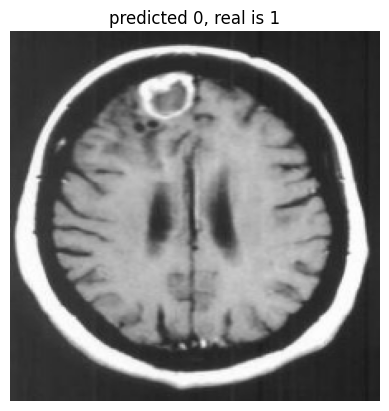

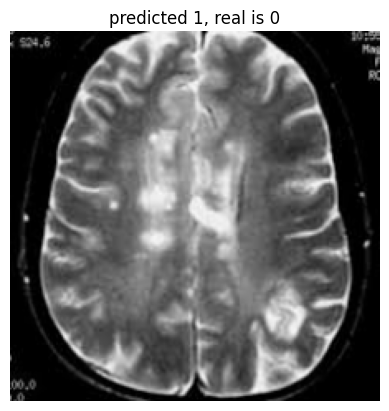

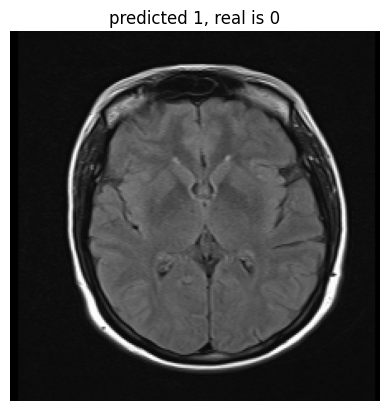

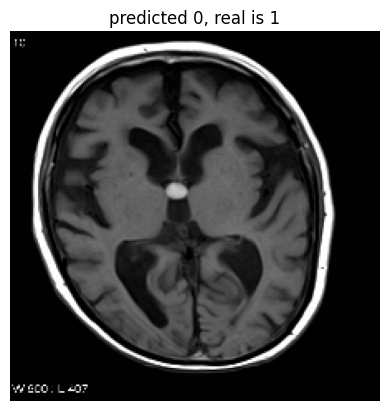

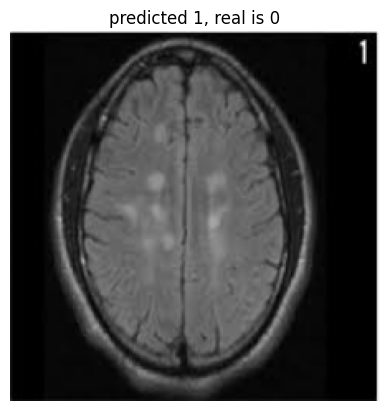

In [22]:
predicted_labels = np.argmax(vgg16_predictions, axis=1)
incorrect_indices = np.where(predicted_labels != y_test_labels)[0]

for idx in incorrect_indices:
    plt.imshow(X_test[idx])
    plt.title(f'predicted {predicted_labels[idx]}, real is {y_test_labels[idx]}')
    plt.axis('off')
    plt.show()

save

In [23]:
# vgg16_model.save('../models/VGG_16.keras')